# 🧠 Language Identification with Deep Learning & Traditional ML  
This notebook presents a complete solution for **Language Identification**, the task of automatically detecting the language of a given text. It combines both **deep learning** and **traditional machine learning** approaches to explore and compare performance across models.

## 📌 Project Highlights
- **Dataset**: Downloaded from [Kaggle - Language Identification Dataset](https://www.kaggle.com/datasets/zarajamshaid/language-identification-datasst)
- **Data Preprocessing**: Minimal cleaning to remove noise, punctuation, and empty records
- **Models Used**:
  - Deep Neural Network with `Embedding`, `Bidirectional LSTM`, `Attention`, and `Dropout` layers
  - Traditional Machine Learning using `CountVectorizer` and `Multinomial Naive Bayes`
- **Evaluation**: Accuracy, F1-score, and confusion matrix
- **Goal**: Build a strong multilingual text classifier and compare learning approaches

> This project is part of my personal portfolio to demonstrate NLP skills for real-world tasks such as text classification and language detection.

---


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("../data/raw/dataset.csv")
df.head()

,Text,language
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian
1,sebes joseph pereira thomas på eng the jesuit...,Swedish
2,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,Thai
3,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,Tamil
4,de spons behoort tot het geslacht haliclona en...,Dutch


In [4]:
df.language.unique()

array(['Estonian', 'Swedish', 'Thai', 'Tamil', 'Dutch', 'Japanese',
       'Turkish', 'Latin', 'Urdu', 'Indonesian', 'Portugese', 'French',
       'Chinese', 'Korean', 'Hindi', 'Spanish', 'Pushto', 'Persian',
       'Romanian', 'Russian', 'English', 'Arabic'], dtype=object)

In [5]:
for language in df.language.unique():
    sample_text = df[df['language'] == language].iloc[1]['Text'][:50]
    print(f"Language: {language} -> {sample_text}")

Language: Estonian -> dorota rabczewska artistinimega doda sündinud  vee
Language: Swedish -> theokritos herdediktning har tjänat som förebild f
Language: Thai -> การฟาดฟันของบรรดาสาวงามในกองประกวด miss beauty and
Language: Tamil -> ஆங்கில எழுத்துக்களை மட்டும் அல்லாமல் பன்மொழி எழுத்
Language: Dutch -> de prinses was als erfgename van polen een goede p
Language: Japanese -> シャーリー・フィールドは、サン・ベルナルド・アベニュー沿い市民センターとrtマーティン高校に隣接して
Language: Turkish -> arianespace şirketi vegayı kutupsal ve güneş eşzam
Language: Latin -> imprimat psalterium quzhayae librum primum imprima
Language: Urdu -> زلاتان ابراھیموویچ zlatan ibrahimović سویڈش تلفظ [
Language: Indonesian -> walter kaudern dalam bukunya menyatakan wawo lage 
Language: Portugese -> diante destes gerenciamentos podendo ser feitos pe
Language: French -> la chirurgie comprenant principalement lablation d
Language: Chinese -> 年月日，參與了「snh第三屆年度金曲大賞best 」。月日，出演由优酷视频，盟将威影视，嗨乐娱乐及世
Language: Korean -> 효모는 세포 수준의 생물학에서 모델 생물의 첫 번째 본보기로 간주해도 좋을 것이다 호흡 및

Checking for any missing (null) values in the dataset 


In [6]:
print(df["Text"].isna().sum(), 'Null Data ')

0 Null Data 


 Removing duplicate records from the dataset to ensure data quality 


In [7]:
print(df["Text"].duplicated().sum(), 'Duplicated -> Removed!')
df.drop_duplicates(inplace=True)

141 Duplicated -> Removed!


 Exploring the number of samples available for each language in the dataset 


/tmp/ipykernel_283585/411115094.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=s.index, y=s.values, palette="viridis");


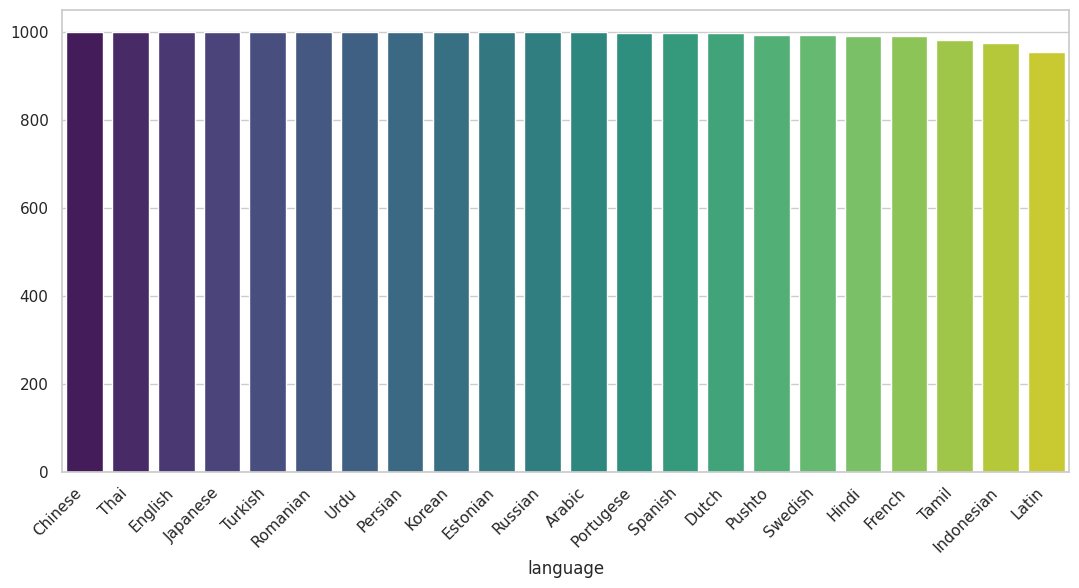

In [8]:
plt.figure(figsize=(13, 6))
sns.set(style="whitegrid")
s = df['language'].value_counts()
plt.xticks(rotation=45, ha='right', fontsize=11)
sns.barplot(x=s.index, y=s.values, palette="viridis");

The dataset is fairly balanced, with a similar number of sentences across all languages. 
 
---

 Checking the distribution of sentence lengths in the dataset.



<Axes: ylabel='length'>

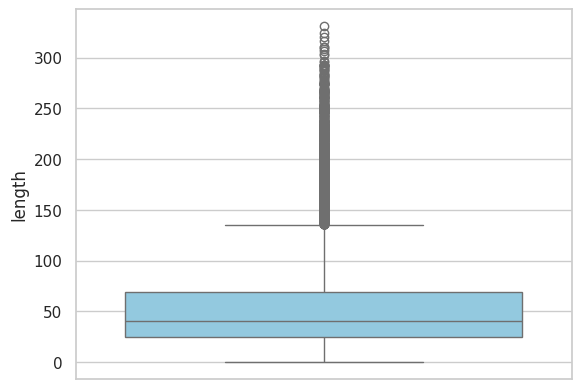

In [9]:
df['length'] = df['Text'].apply(str.split).apply(len)
sns.boxplot(df['length'], color='skyblue')

In [10]:
df['length'].describe()

count    21859.00000
mean        53.42829
std         44.79464
min          0.00000
25%         25.00000
50%         41.00000
75%         69.00000
max        331.00000
Name: length, dtype: float64

 Removing noisy samples: filtering out sentences longer than 150 words to improve data quality 


In [12]:
df = df[df['length'] <= 150]
df = df[df['length'] >= 4]
df['length'].describe()

count    19255.000000
mean        50.462529
std         30.552477
min          4.000000
25%         27.000000
50%         42.000000
75%         67.000000
max        150.000000
Name: length, dtype: float64

Cleaning sentences by removing punctuation marks to simplify the text for better processing 


In [97]:
import re

def clean_text(text):
    text_no_punct = re.sub(r'[^\w\s]', '', text)
    text_clean = re.sub(r'\s+', ' ', text_no_punct)
    return text_clean.strip()

df['Text'] = df['Text'].apply(clean_text)
df = df[df['Text'].str.strip().astype(bool)]

In [14]:
df['length'] = df['Text'].apply(str.split).apply(len)
df['length'].describe()

count    19255.000000
mean        50.462529
std         30.552477
min          4.000000
25%         27.000000
50%         42.000000
75%         67.000000
max        150.000000
Name: length, dtype: float64

 Tokenizing the text data to convert words into numerical sequences for model input 


In [107]:
import tensorflow as tf


tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True, oov_token='<OOV>')
tokenizer.fit_on_texts(df['Text'])
sequence = tokenizer.texts_to_sequences(df['Text'])
word_idx = tokenizer.word_index
maxlen = 400
padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=maxlen, padding='post', truncating='post')

In [108]:
print(len(word_idx))
class_nums = df.language.unique().size
print(class_nums)

6908
22


In [109]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['language'])

X_train, X_test, y_train, y_test = train_test_split(padded_sequence, encoded_labels, test_size=0.2, stratify=df['language'])

 Building the deep learning model with Embedding, Bidirectional LSTM, Attention, and Dense layers 

In [110]:
from tensorflow.keras.layers import Bidirectional, Input, Dense, LSTM, Dropout, Embedding, GlobalMaxPooling1D, GlobalAveragePooling1D, Attention
from tensorflow.keras.models import Model

inputs = Input(shape=(maxlen,))
x = Embedding(input_dim=len(word_idx) + 1, output_dim=128, input_length=maxlen)(inputs)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Attention()([x, x])
x = GlobalAveragePooling1D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(class_nums, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

/home/mohammad/Documents/SentimentAnalysis/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 400)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_28        │ (None, 400, 128)  │    884,352 │ input_layer_28[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_23    │ (None, 400, 128)  │     98,816 │ embedding_28[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_8         │ (None, 400, 128)  │          0 │ bidirectional_23… │
│ (Attention)         │                   │            │ bidirectional_23… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ attention_8[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_48          │ (None, 128)       │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 128)       │     16,512 │ dropout_48[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_49          │ (None, 128)       │          0 │ dense_48[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_49 (Dense)    │ (None, 22)        │      2,838 │ dropout_49[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,002,518 (3.82 MB)

 Trainable params: 1,002,518 (3.82 MB)

 Non-trainable params: 0 (0.00 B)

In [114]:
from tensorflow.keras.optimizers import Adam

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)]


model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=320, callbacks=callbacks)

Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9786 - loss: 0.0873 - val_accuracy: 0.9758 - val_loss: 0.1063
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9821 - loss: 0.0774 - val_accuracy: 0.9748 - val_loss: 0.1123
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9766 - loss: 0.0963 - val_accuracy: 0.9771 - val_loss: 0.0988
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9842 - loss: 0.0672 - val_accuracy: 0.9758 - val_loss: 0.1064
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9816 - loss: 0.0729 - val_accuracy: 0.9785 - val_loss: 0.0967
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9829 - loss: 0.0669 - val_accuracy: 0.9760 - val_loss: 0.1059
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9850 - loss: 0.0629 - val_accuracy: 0.9730 - val_loss: 0.1200
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9849 - loss: 0.0623 - val_accuracy: 0.9764 - v

 Evaluating the deep learning model's performance using accuracy and loss metrics 


In [115]:
model.evaluate(X_test, y_test)

137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9733 - loss: 0.1317


[0.11263883858919144, 0.9750686287879944]

In [117]:
model.save('../models/model.keras')

In [151]:
import numpy as np

new_text = "سلام امیدوارم حالتون خوب باشه - اینم از ارزیابی مدل که خودم عشق کردم واقعا"

new_text = clean_text(new_text)
sequence = tokenizer.texts_to_sequences([new_text])
padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=maxlen, padding='post')

label = model.predict(padded_sequence)

predicted_indices = np.argmax(label, axis=1)
predicted_languages = label_encoder.inverse_transform(predicted_indices)

print(predicted_languages)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
['Persian']


Building and evaluating a Multinomial Naive Bayes classifier for baseline language identification performance 


In [185]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df["Text"])

x_train, x_test, y_train, y_test = train_test_split(X, encoded_labels, shuffle=True, stratify=encoded_labels, test_size=0.2)

clf = MultinomialNB()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

Accuracy Score:  0.9208600182982617


              precision    recall  f1-score   support

           0       0.94      0.99      0.97       200
           1       1.00      0.01      0.02       200
           2       0.97      0.99      0.98       199
           3       0.68      0.99      0.81       200
           4       1.00      0.97      0.99       200
           5       0.94      0.98      0.96       198
           6       1.00      0.98      0.99       198
           7       0.99      0.96      0.98       195
           8       0.48      0.91      0.63       200
           9       1.00      0.98      0.99       200
          10       0.98      0.90      0.94       191
          11       0.99      0.99      0.99       200
          12       0.98      0.96      0.97       199
          13       1.00      0.96      0.98       199
          14       0.99      0.99      0.99       200
          15       0.98      0.98      0.98       200
          16       0.97      0.99      0.98

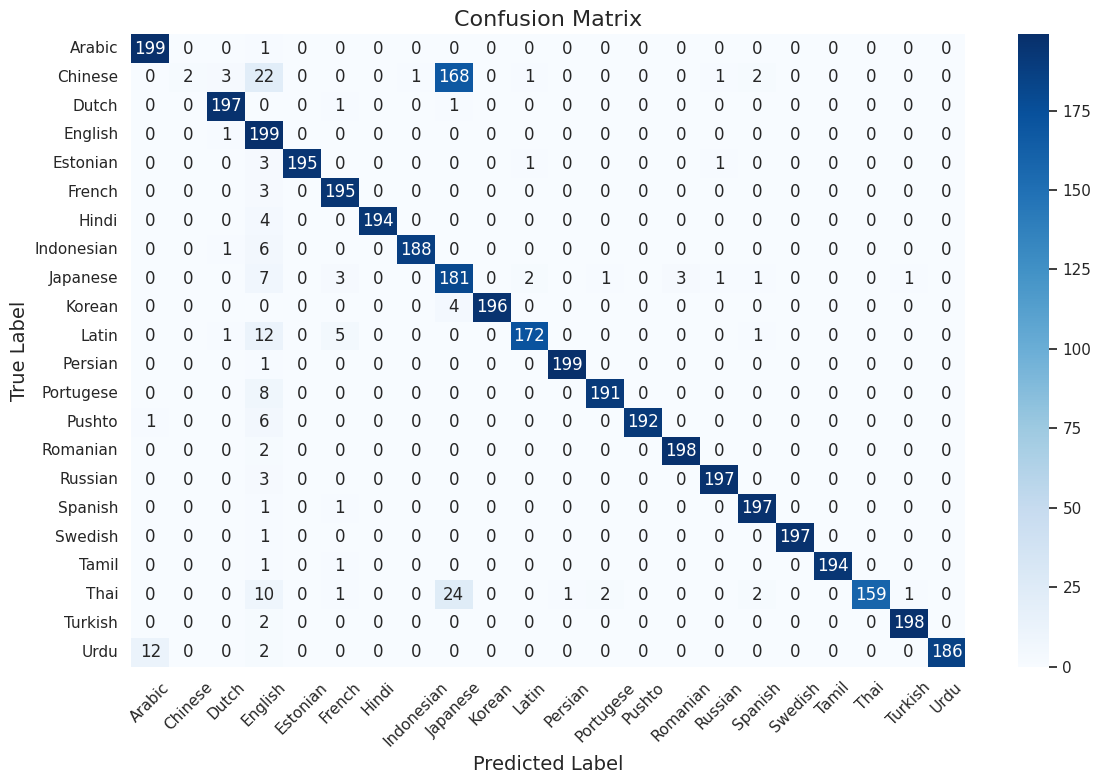

In [190]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy Score: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("\n")
print(classification_report(y_pred=y_pred, y_true=y_test))

cm = confusion_matrix(y_test, y_pred)

# رسم heatmap ماتریس درهم‌ریختگی
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)

plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [194]:
x = vectorizer.transform([new_text])
y = clf.predict(x)

In [198]:
print(label_encoder.inverse_transform(y))

['Persian']


*Jafa DsX*